adapted from: https://towardsdatascience.com/why-start-using-sktime-for-forecasting-8d6881c0a518

In [25]:

import numpy as np
import pandas as pd
import statsmodels.api as sm

In [26]:
# Pull data from stats models for example
df = sm.datasets.macrodata.load_pandas()['data']

# Making a single year/qtr field 
df['q_date'] = df.apply(lambda x: str(int(x['year'])) + '-Q' + str(int(x['quarter'])), axis=1)
# Specifying this as this is a time series and that the frequency is quarterly
df['date'] = pd.PeriodIndex(df['q_date'], freq='Q').to_timestamp()
# Using this as the index
df = df.set_index('date').to_period("Q")

#creating lagged values for forecasting with exogenous variables
df.loc[:, 'realinv_lagged'] = df.loc[:, 'realinv'].shift()
df[['realinv_lagged']] = df[['realinv_lagged']].fillna(method='backfill')

# View df
df

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint,q_date,realinv_lagged
date,,,,,,,,,,,,,,,,
1959Q1,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.980,139.7,2.82,5.8,177.146,0.00,0.00,1959-Q1,286.898
1959Q2,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.150,141.7,3.08,5.1,177.830,2.34,0.74,1959-Q2,286.898
1959Q3,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.350,140.5,3.82,5.3,178.657,2.74,1.09,1959-Q3,310.859
1959Q4,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.370,140.0,4.33,5.6,179.386,0.27,4.06,1959-Q4,289.226
1960Q1,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.540,139.6,3.50,5.2,180.007,2.31,1.19,1960-Q1,299.356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008Q3,2008.0,3.0,13324.600,9267.7,1990.693,991.551,9838.3,216.889,1474.7,1.17,6.0,305.270,-3.16,4.33,2008-Q3,2026.518
2008Q4,2008.0,4.0,13141.920,9195.3,1857.661,1007.273,9920.4,212.174,1576.5,0.12,6.9,305.952,-8.79,8.91,2008-Q4,1990.693
2009Q1,2009.0,1.0,12925.410,9209.2,1558.494,996.287,9926.4,212.671,1592.8,0.22,8.1,306.547,0.94,-0.71,2009-Q1,1857.661


We are going to try to predict 'realgdp'

In [27]:
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.naive import NaiveForecaster

# Setting the target
y = df['realgdp']
# Train/test split
y_train, y_test = temporal_train_test_split(y, test_size=30) #this can be absolutave value (e.g. 30) or a percenatge (e.g. 0.3 == 30%)

# Check shapes
print('Train y shape: ', y_train.shape)
print('Test y shape: ', y_test.shape)

# Making a baseline forecast
forecaster = NaiveForecaster()
forecaster.fit(y_train)
y_pred = forecaster.predict(fh=1) #forecasting one step ahead

print(y_pred)

Train y shape:  (173,)
Test y shape:  (30,)
2002Q2    11477.868
Freq: Q-DEC, dtype: float64


This can be done differently, instead of specifying the amount of data we want in the test set, we can use a cutoff. 

Also, we can use an absolute forecasting horizon. This means we will make predictions for the entire test set.

In [28]:
from sktime.forecasting.base import ForecastingHorizon
from sktime.utils.plotting import plot_series
import seaborn as sns
sns.set(rc={'figure.figsize':(20,16)})

In [29]:
#specific data points
fh_abs = ForecastingHorizon(y_test.index, is_relative=False)  
print(f"Absolute FH: {fh_abs}")

#last point in the training series
cutoff = pd.Period("2002-01-01", freq="Q")
fh_rel = fh_abs.to_relative(cutoff)
print(f"\nRelative FH ahead: {list(fh_rel)}")

#29 quarters after the last point in the training series
cutoff_insample = pd.Period("2009-09-01", freq="Q")
fh_rel_insample = fh_abs.to_relative(cutoff_insample)
print(f"\nRelative FH in-sample: {list(fh_rel_insample)}")

forecaster = NaiveForecaster().fit(y_train)
y_pred_rel = forecaster.predict(fh=fh_rel)
y_pred_rel_insample = forecaster.predict(fh=fh_rel_insample)

Absolute FH: ForecastingHorizon(['2002Q2', '2002Q3', '2002Q4', '2003Q1', '2003Q2', '2003Q3',
             '2003Q4', '2004Q1', '2004Q2', '2004Q3', '2004Q4', '2005Q1',
             '2005Q2', '2005Q3', '2005Q4', '2006Q1', '2006Q2', '2006Q3',
             '2006Q4', '2007Q1', '2007Q2', '2007Q3', '2007Q4', '2008Q1',
             '2008Q2', '2008Q3', '2008Q4', '2009Q1', '2009Q2', '2009Q3'],
            dtype='period[Q-DEC]', name='date', freq='Q-DEC', is_relative=False)

Relative FH ahead: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]

Relative FH in-sample: [-29, -28, -27, -26, -25, -24, -23, -22, -21, -20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0]


(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='realgdp'>)

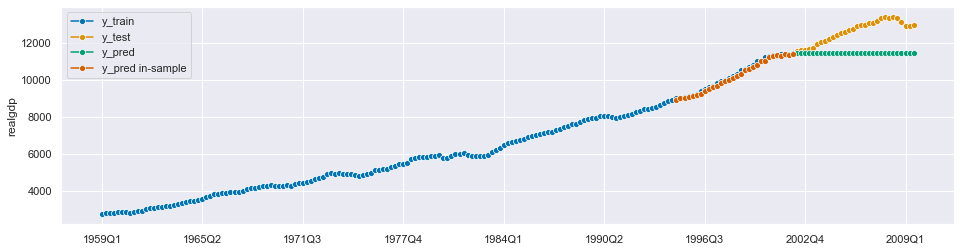

In [30]:
plot_series(y_train, y_test, y_pred_rel, y_pred_rel_insample, labels=["y_train", "y_test", "y_pred", "y_pred in-sample"])

Auto-arima

C:\Users\steph\anaconda3\envs\montVenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\steph\anaconda3\envs\montVenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\steph\anaconda3\envs\montVenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\steph\anaconda3\envs\montVenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stat

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='realgdp'>)

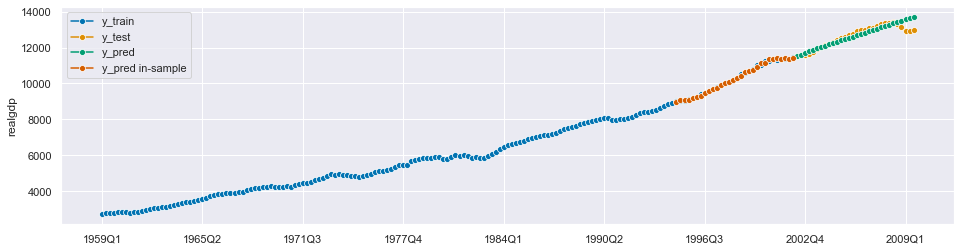

In [32]:
from sktime.forecasting.arima import AutoARIMA

forecaster = AutoARIMA(sp=4)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh=fh_abs)
y_pred_rel_insample = forecaster.predict(fh=fh_rel_insample)

plot_series(y_train, y_test, y_pred, y_pred_rel_insample, labels=["y_train", "y_test", "y_pred", "y_pred in-sample"])

### Multivariate forecast

C:\Users\steph\anaconda3\envs\montVenv\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\steph\anaconda3\envs\montVenv\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\steph\anaconda3\envs\montVenv\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\steph\anaconda3\envs\montVenv\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\steph\anaconda3\envs\montVenv\lib\site-packages\pmdarima\arima\arima.py:577: UserWarning: As of version 1.5.0 'typ' is no longer a valid arg for predict. In future versions this will raise a 

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='realgdp'>)

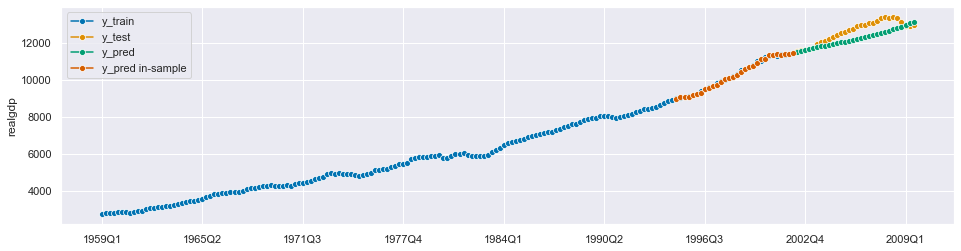

In [35]:
y = df['realgdp']
X = df[['realinv_lagged']] #could be more features
y_train, y_test, X_train, X_test = temporal_train_test_split(y, X, test_size=30)
fh_abs = ForecastingHorizon(y_test.index, is_relative=False) 

forecaster = AutoARIMA(sp=4)
forecaster.fit(y_train, X_train)
y_pred = forecaster.predict(X=X_test, fh=fh_abs)
y_pred_rel_insample = forecaster.predict(X=X_test, fh=fh_rel_insample)

plot_series(y_train, y_test, y_pred, y_pred_rel_insample, labels=["y_train", "y_test", "y_pred" , "y_pred in-sample"])

### Reduction

Reduction is the process of using sliding windows to ensure the time series aspect (each row is dependant on the one(s) before) is maintained for algorithms that this would not be native (in tabular data). 

Below is an example using linear regression.

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='realgdp'>)

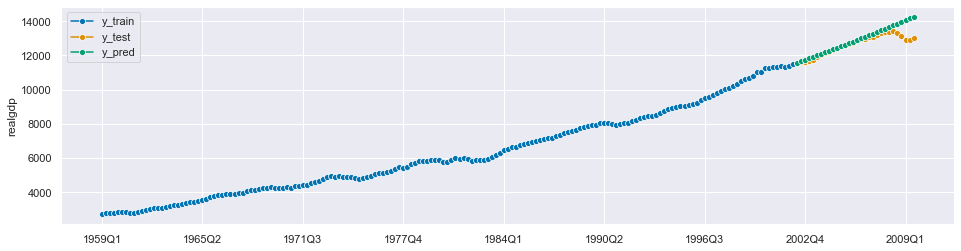

In [39]:
from sktime.forecasting.compose import make_reduction
from sklearn.linear_model import LinearRegression

y = df['realgdp']
y_train, y_test = temporal_train_test_split(y, test_size=30)

regressor = LinearRegression()
forecaster = make_reduction(estimator=regressor, strategy='recursive', window_length=4)
forecaster.fit(y_train)
y_pred = forecaster.predict(np.arange(1, y_test.size+1))
#y_pred_rel_insample = forecaster.predict(fh=fh_rel_insample)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

### Evaluating models with sktime

In [40]:
from sktime.forecasting.theta import ThetaForecaster
from sktime.performance_metrics.forecasting import make_forecasting_scorer

In [41]:
#custom mape calculated on predictions with a ceiling
def custom_mape(y: np.array, y_hat: np.array, multioutput: str):
    metrics_dict = {'uniform_average': np.mean(np.abs((y - np.ceil(y_hat)) / y)),
                    'raw_values': np.abs((y - np.ceil(y_hat)) / y)}
    try:
        return metrics_dict[multioutput]
    except KeyError:
        print("multioutput not specified correctly - "
              "pick `raw_values` or `uniform_average`")

In [42]:
forecaster = ThetaForecaster()
forecaster.fit(y_train)
y_pred = forecaster.predict(np.arange(1, y_test.size+1))
        
mape_changed = make_forecasting_scorer(func=custom_mape, 
                                       multioutput = 'uniform_average')
mape_changed_per_row = make_forecasting_scorer(func=custom_mape, 
                                               multioutput = 'raw_values')
print(f"custom MAPE: {mape_changed(y_test, y_pred)}")
print(f"custom MAPE per row:\n{mape_changed_per_row(y_test, y_pred).head()}")

custom MAPE: 0.05751249071487726
custom MAPE per row:
2002Q2    0.001020
2002Q3    0.003918
2002Q4    0.002054
2003Q1    0.004020
2003Q2    0.009772
Freq: Q-DEC, dtype: float64


This is good as often a time series forecast will degenerate as the horizon grows, this is apparent in this example.